# Show some basics and options for the retrieval
This notebooks reads a sample spectra and illustrates the retrieval of the PSD similar to Barret et al. (2019) and some sensitivities for the particle properties

### if you make changes to the src code (everything which is in PSDretrieval/PSDretrieval ) you should run:
    "python3 setup.py install --user"
    and commit & push the changes with a meaningful commit-message ;-)
    
    you can compile and test the code with one line:
    "python3 setup.py install --user && python3 PSDretrieval/test/testNEW.py"
    Before the modifications apply to this notebook you need to click on "Kernel/Restart & Run All"

In [1]:
from PSDretrieval import processRadar as pR
from PSDretrieval import plotting as pl
from PSDretrieval import scattering as sc
from PSDretrieval import retrievalUtils as rU
import snowScatt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load sample from data
date = "20190113"
time = "06:18:04"
hcenter=1600 #[m]
#load data (this is a window of time and height, which can define by additional input parameters)
SpecWindow  = pR.loadSpectra(loadSample=False,dataPath="/data/obs/campaigns/tripex-pol/processed/",createSample=True,date=date,time=time,tRange=1,hRange=180,hcenter=hcenter)
#extract a single spectra from the time-height window
SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)
#load the Spectral Window
PeaksWindow  = pR.loadPeaks(loadSample=False,dataPath="/data/obs/campaigns/tripex-pol/spectralPeaks/",createSample=True,date=date,time=time,tRange=1,hRange=180,hcenter=hcenter)

load files: /data/obs/campaigns/tripex-pol/processed/tripex_pol_level_0/2019/01/13/20190113_*_tripex_pol_3fr_spec_filtered_regridded.nc
merging datasets done
load file:/data/obs/campaigns/tripex-pol/spectralPeaks/


In [3]:
# #load sample data (this is a window of time and height, which can define by additional input parameters)
# SpecWindow  = pR.loadSpectra()
# #extract a single spectra from the time-height window
# SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)
# #load detected peaks from processed file
# PeaksWindow  = pR.loadPeaks()

## plot the sample spectrum

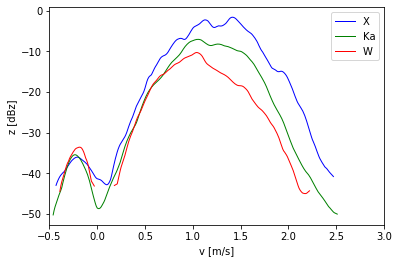

In [4]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax = pl.plotObsSpectra(SpecSingle,ax)

## get the vertical wind estimate

In [5]:
#add vertical wind information to 
#SpecWindow = pR.addVerticalWindToSpecWindow(SpecWindow,PeaksWindow)

## alternatively: set w yourself
Attention this assumes a constant w for the whole SpecWindow (time-height) window

In [6]:
SpecWindow = pR.addVerticalWindToSpecWindow(SpecWindow,None,addManually=True,manualW=0.23)

In [7]:
#extract a single spectra from the time-height window (no with the W-information)
SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)
#get again the - now shifted - single spectra from the SpecWindow 
SpecSingleWshifted  = pR.shiftSpectra(SpecSingle)

## plot W-shifted spectra

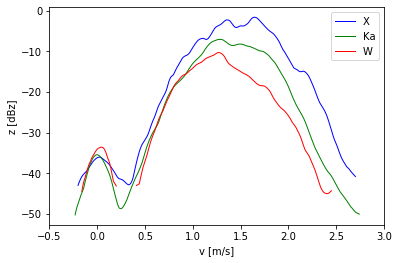

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax = pl.plotObsSpectra(SpecSingleWshifted,ax)

## cut noisy part and plot spectra again

/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


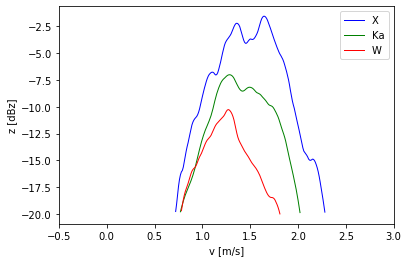

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=1)
#cut spectra
zeThreshold=-20
SpecWindow = pR.cutLowZe(SpecWindow,zeThreshold=zeThreshold)
SpecSingleWshiftedCut = pR.cutLowZe(SpecSingleWshifted.copy(),zeThreshold=zeThreshold)
ax = pl.plotObsSpectra(SpecSingleWshiftedCut,ax)

## plot single-spectra DV vs. DWR

/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


plot DV vs DWR for a single spectrum


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


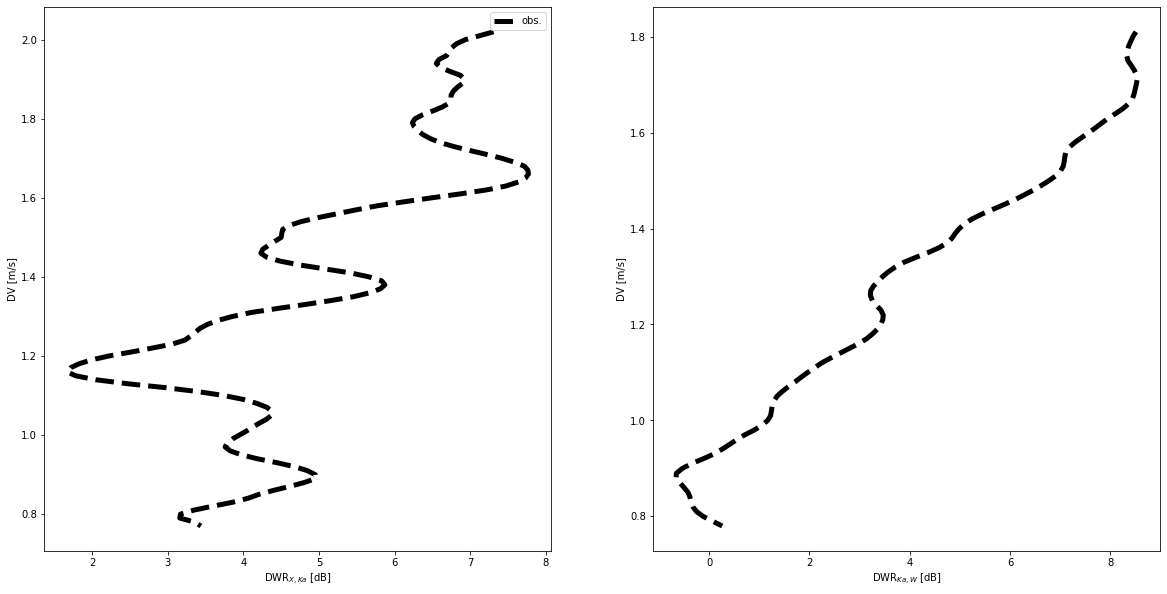

In [10]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
__ = pl.plotSDWRvsDVobs(SpecSingleWshiftedCut,axes2)

## plot average DV vs. DWR from time-height window

/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


plot average DV vs DWR for a time-height window


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


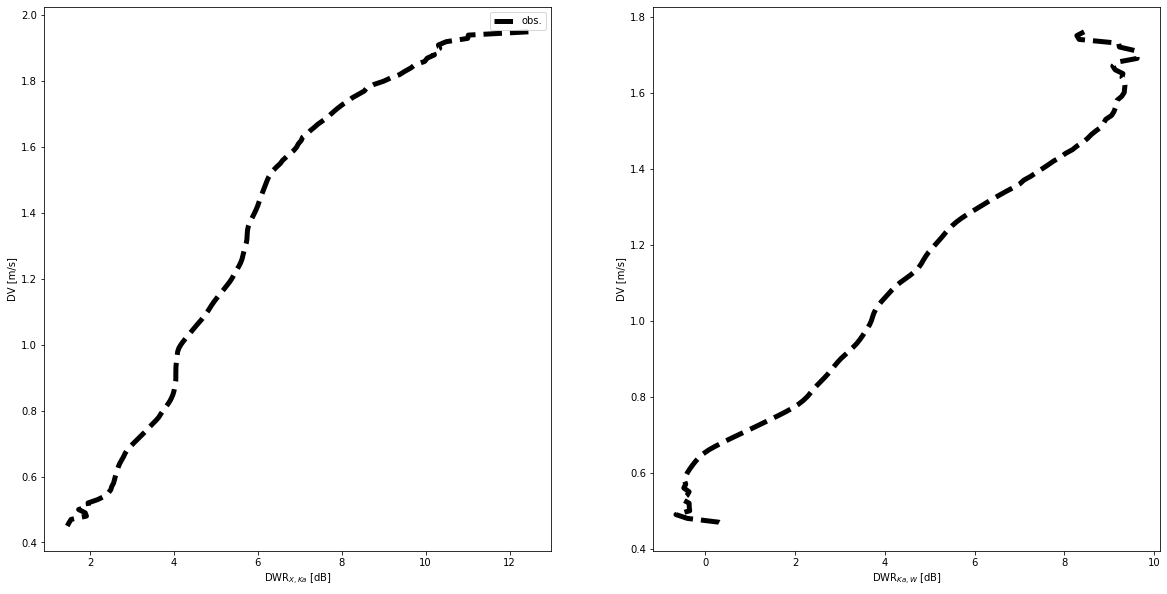

In [11]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
__ = pl.plotSDWRvsDVobs(SpecWindow,axes2)

## how do the snowscatt models fit to the observed DV-DWR relation

### mixcoldend with all riming degrees

/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


plot average DV vs DWR for a time-height window


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


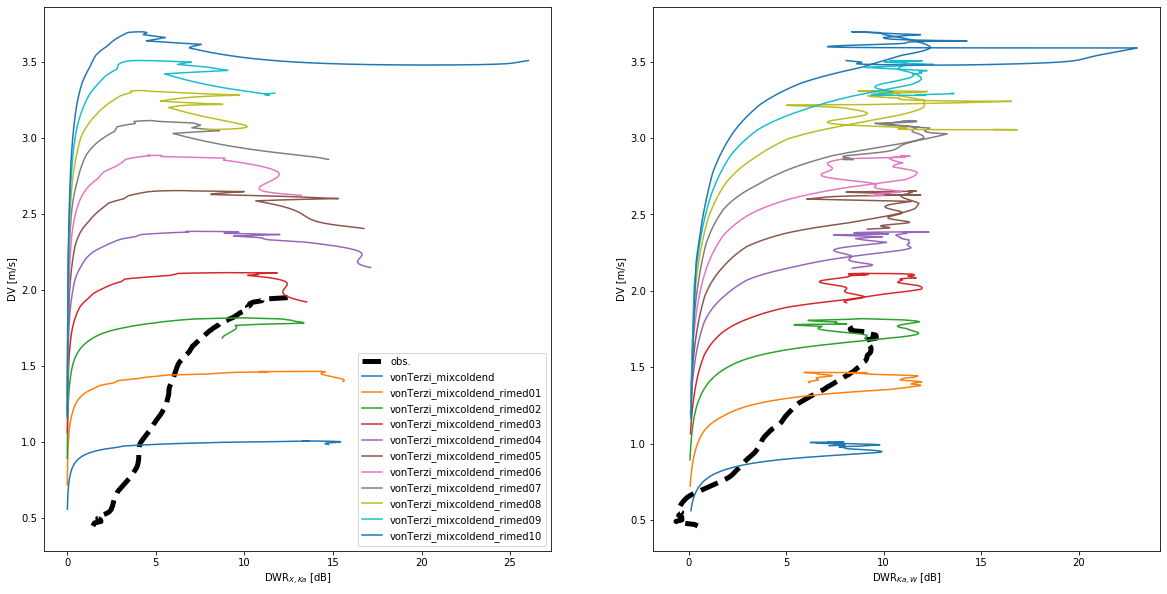

In [12]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
axes2 = pl.plotSDWRvsDVobs(SpecWindow,axes2)
#get names of all particle types
allParticleTypes        = [*snowScatt.snowLibrary._fileList.keys()]
#select an aggregate type
aggType = 'vonTerzi_mixcoldend'
#get a list of all particle-type names from this aggregate type with different riming degrees
allRimDegr = [k for k in allParticleTypes if aggType in k]
for pType in allRimDegr:
    #get spectral-resolved particle properties
    Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(pType,temperature=float(SpecSingle["ta"].values))
    #calculate spectral DWRs
    DWRxk = Zx-Zk; DWRkw = Zk-Zw
    axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,pType)
axes2[0].legend()

### all unrimed vonTerzis'

/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


plot average DV vs DWR for a time-height window


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


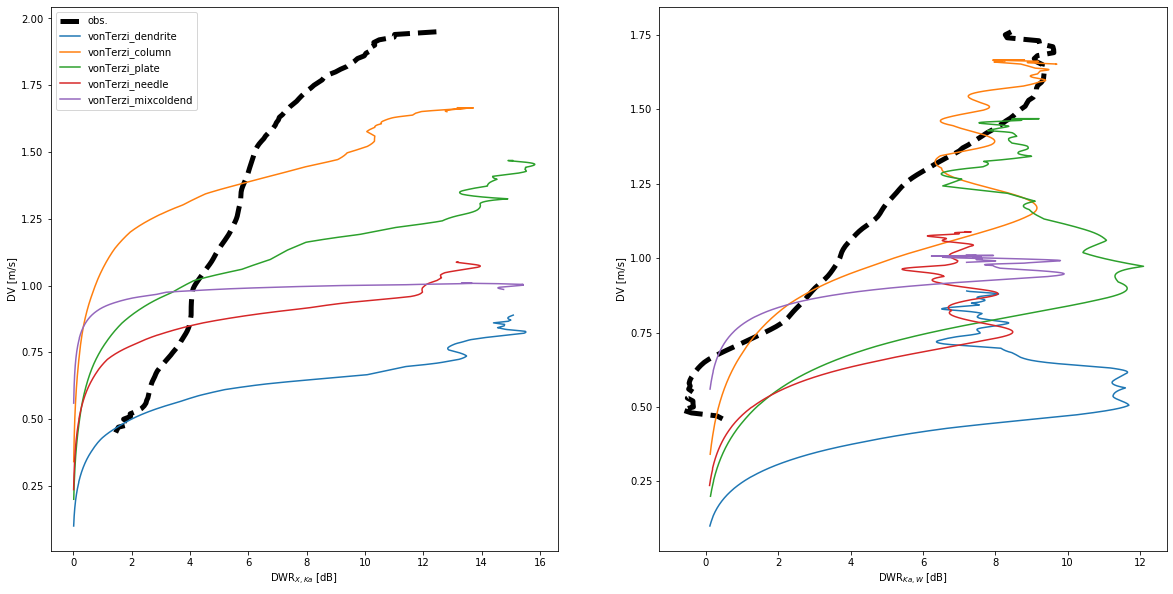

In [13]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
allParticleTypes        = [*snowScatt.snowLibrary._fileList.keys()]
axes2 = pl.plotSDWRvsDVobs(SpecWindow,axes2)
allUnrimVT = [k for k in allParticleTypes if ("vonTerzi_" in k and not "rimed" in k)]
for pType in allUnrimVT:
    #get spectral-resolved particle properties
    Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(pType)
    #calculate spectral DWRs
    DWRxk = Zx-Zk; DWRkw = Zk-Zw
    axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,pType)
axes2[0].legend()

### all Leinonens' and Ori

/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


plot average DV vs DWR for a time-height window


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0, 2)

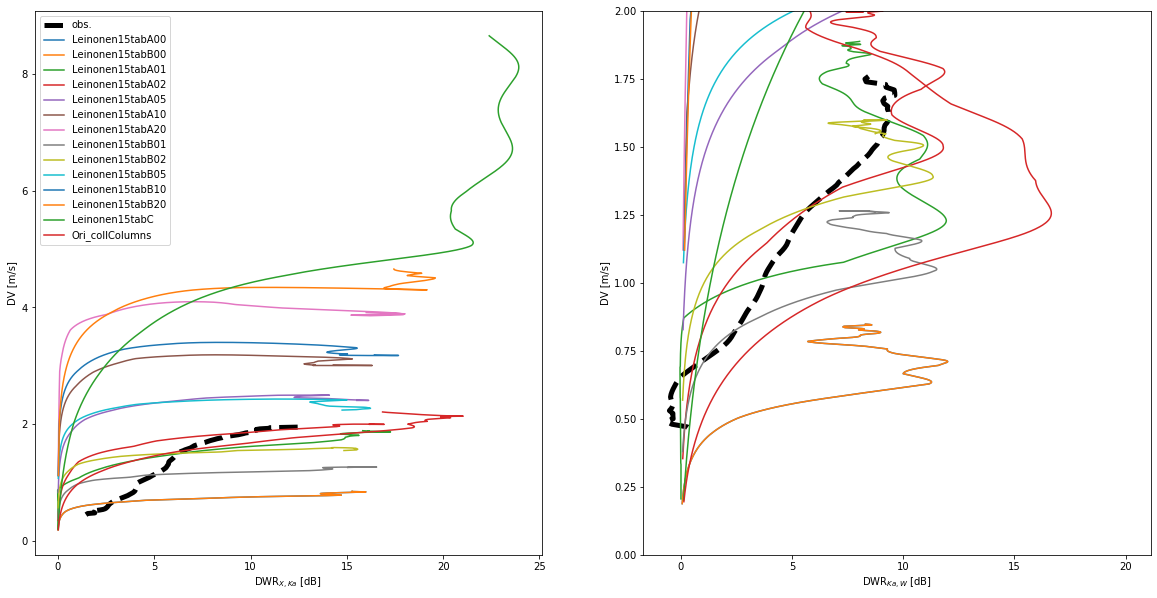

In [14]:
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
allParticleTypes        = [*snowScatt.snowLibrary._fileList.keys()]
axes2 = pl.plotSDWRvsDVobs(SpecWindow,axes2)
allUnrimVT = [k for k in allParticleTypes if ("Leinonen" in k or "Ori" in k)]
for pType in allUnrimVT:
    #get spectral-resolved particle properties
    Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(pType)
    #calculate spectral DWRs
    DWRxk = Zx-Zk; DWRkw = Zk-Zw
    axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,pType)
axes2[0].legend()
axes2[1].set_ylim([0,2])

### find best fitting particle type

Start: find best matching particle type in DV-DWR spaces


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


plot average DV vs DWR for a time-height window


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40

/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40

best Ptype: vonTerzi_column


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


plot average DV vs DWR for a time-height window


/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


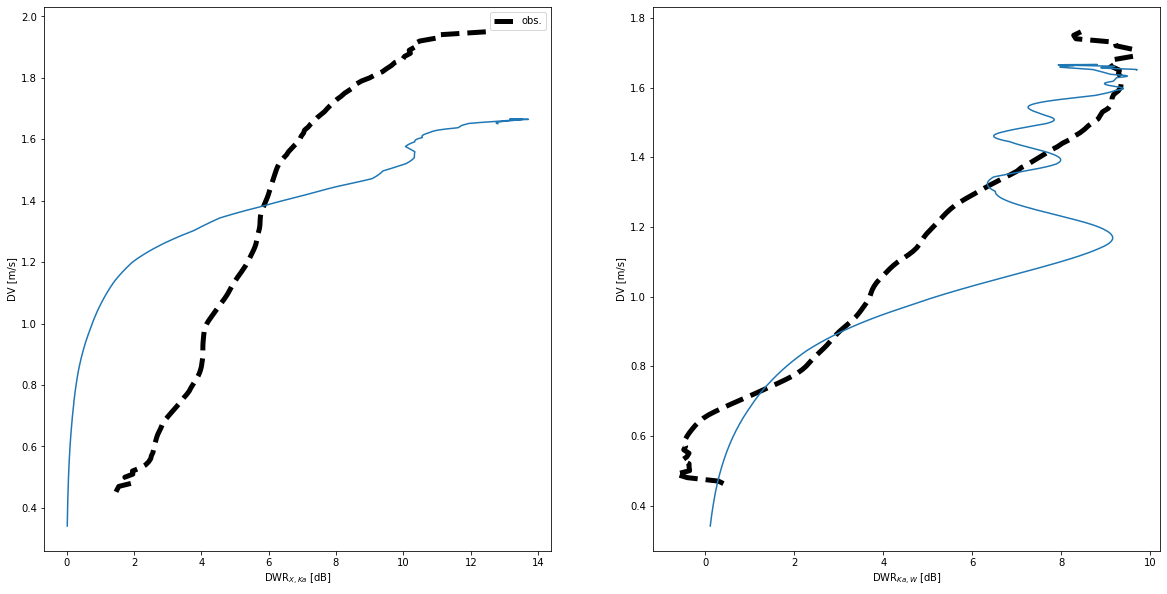

In [15]:
#should we use DWR_X_Ka, DWR_Ka_W or both?
whichDWRsToUse="DWR_Ka_W" # choose from ["both","DWR_Ka_W",""DWR_X_Ka]
#find best fitting particle type
ParticleTypeList = [*snowScatt.snowLibrary._fileList.keys()] #read https://www.python.org/dev/peps/pep-0448/ for the [*...] formalism
#ParticleTypeList = [k for k in allParticleTypes if 'vonTerzi_mixcoldend' in k]
#ParticleTypeList = ["vonTerzi_mixcoldend","vonTerzi_mixcoldend_rimed05"]
[bestPartType,orderedListPartType] = rU.findBestFittingPartType(ParticleTypeList,SpecWindow,whichDWRsToUse=whichDWRsToUse)
#plot sDWR vs DV for best fitting particle type
Zx, Zk, Zw, Dmax, K2, vel = sc.model3fOne(bestPartType)
DWRxk = Zx - Zk; DWRkw = Zk - Zw
fig2,axes2 = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
axes2 = pl.plotSDWRvsDVobs(SpecWindow,axes2)
axes2 = pl.plotSDWRvsDVmodel(vel,DWRxk,DWRkw,axes2,bestPartType)

## plot mass and Ze (at Ka-Band) for each DV bin from the selected model

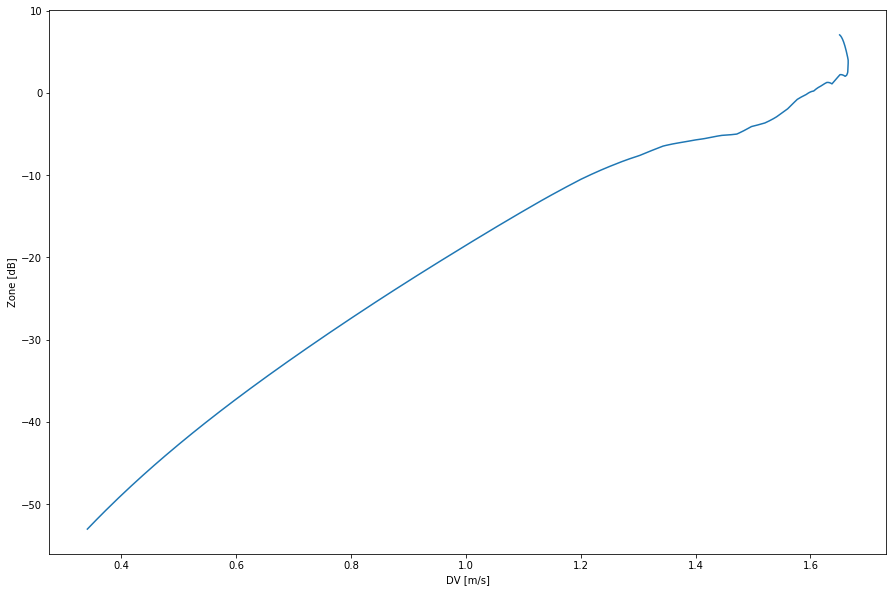

In [16]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
ax = pl.plotSinglePartZe(bestPartType,ax,freq="Ka")

## derive size distribution by dividing the observed spectral power by the single particle backscattering cross section at each DV-bin N(D)=ze/sigma_single

/usr/lib/python3/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/usr/lib/python3/dist-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
/home/mkarrer/.local/lib/python3.8/site-packages/PSDretrieval/retrievalUtils.py:193: RuntimeWarning: divide by zero encountered in true_divide
  NumConNormD = NumCon[:-1]/-np.diff(DmaxModelAtObsDVgrid)


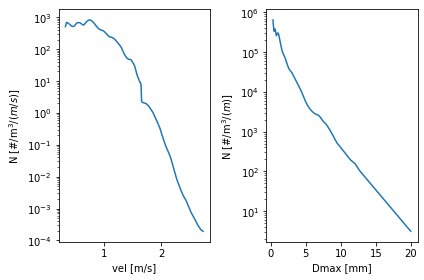

In [17]:
velObs,NumConNormV,NumConNormD,DmaxAtObsDVgrid = rU.calculateNumberForEachDVbin(Zk,SpecSingleWshifted.KaSpecH.values,vel,-SpecSingleWshifted.KaSpecH.doppler.values,DmaxModel=Dmax)
fig,axes = plt.subplots(nrows=1,ncols=2)
axes = pl.plotNumCon(NumConNormV,NumConNormD,axes,velObs,DmaxAtObsDVgrid*1e3)
plt.tight_layout()

## do some cross checks (e.g. ZeX from observation and forward operated from retrieval)

In [18]:
rU.crossCheckIntegratedProp(DmaxAtObsDVgrid,NumConNormD,SpecSingle.XSpecH,bestPartType)

Nretrieval 486.88481182108865 1/m^3 IWCretrieval 0.05702397396932648 g/m^3 MassMedianDiam 3.9274061311562702 mm
ZeXobs:  15.971486899195096 ZxFromRetrievedPSD 16.350429845194366
